<a href="https://colab.research.google.com/github/EliTaub1/bio108_tutorial/blob/main/cephalopod_salinity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cephalopod Distribution by Salinity
When analyzing the distribution of taxa, it is critical to understand which climactic variables are influencing their range. Here, we examine the distribution of cephalopods in the Canary Current to see if different families of cephalopods have different ocean salinity preferences.

First, we install and import pacakges:

In [ ]:
#install packages
! pip install rasterio fiona rioxarray rasterstats

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 3.3 MB/s eta 0:00:00


In [ ]:
#import packages
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
import rasterio.plot
from shapely.geometry import Point
import rasterstats

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


For cephalopod distribution, we are using data from Luna et al (2025), which analyzed bathymetric preferences of 90 species collected from bottom trawl surveys off the northwest coast of Africa between 2004 and 2012 (https://datadryad.org/dataset/doi:10.5061/dryad.15dv41p6j). Data was downloaded as a csv and uploaded to Drive.

In [ ]:
#Import cephalopod data
cephalopod_path = "/content/drive/MyDrive/Colab Notebooks/Supporting_data_-_Cephalopods_distribution_paper.csv"
cephalopod = pd.read_csv(cephalopod_path)

#create GPD with cephalopod locations as spatial points
cephalopod_coords = cephalopod[["Long L", "Latit L"]]
cephalopod_coords = cephalopod_coords.to_numpy()
cephalopod_locations = [Point(xy) for xy in cephalopod_coords]

cephalopod_locations = gpd.GeoDataFrame(cephalopod_locations,
                                  columns=['geometry'],
                                  crs="epsg:4326")
#add order data for each data point
cephalopod_locations["Family"] = cephalopod["Family"]
#remove NA locations
cephalopod_locations = cephalopod_locations.loc[(cephalopod_locations.is_empty) == False]

For salinity, we are using mean salinity data from 2000-2010 from Bio-ORACLE (https://bio-oracle.org/). Data on salinity was downloaded as a .nc file and uploaded to Drive. First, we convert our salinity data to a TIFF file in order to work better with rasterio (which otherwise will have no crs).

In [ ]:
#Source: https://help.marine.copernicus.eu/en/articles/5029956-how-to-convert-netcdf-to-geotiff
import xarray as xr
import rioxarray as rio

#open salinity with xarray and rioxarray
salinity_path = "/content/drive/MyDrive/Colab Notebooks/so_baseline_2000_2019_depthsurf_a5c8_8d8a_48fb_U1741627836120.nc"
salinity = xr.open_dataset(salinity_path)
sal_data = salinity["so_mean"]
sal_data = sal_data.rio.set_spatial_dims(x_dim='longitude', y_dim='latitude')
#explicitly set crs
sal_data = sal_data.rio.write_crs("epsg:4326", inplace=True)
#save as tif file
sal_data.rio.to_raster("/content/drive/MyDrive/Colab Notebooks/world_salinity.tif")

#open with rasterio
salinity_raster = rasterio.open("/content/drive/MyDrive/Colab Notebooks/world_salinity.tif")

Now, we extract salinity data for each of the datapoints and add it back to the cephalopod location GeoDataFrame.

In [ ]:
#extract salinity data
salinity_results = rasterstats.point_query(
    #points
    cephalopod_locations,
    salinity_raster.read(1),
    nodata = salinity_raster.nodata,
    affine = salinity_raster.transform,
    interpolate='nearest'
)
#add salinity data back to cephalopod data
cephalopod_locations["salinity"] = salinity_results

Next, we group the data by order and calculate salinity summary stastics for each order of cephalopod.

In [ ]:
#calculate salinity summary statistics by order
mean_salinity_order = cephalopod_locations.groupby(["Family"])["salinity"].describe()

#find minimum and maximum salinity values of cephalopods
min_sal = cephalopod_locations["salinity"].min()
max_sal = cephalopod_locations["salinity"].max()

Lastly, we plot our data. Note that our y axis is set to the range of salinity values at which cephalopods are found, as this gives a better idea of the range of values that may exist than starting at 0.

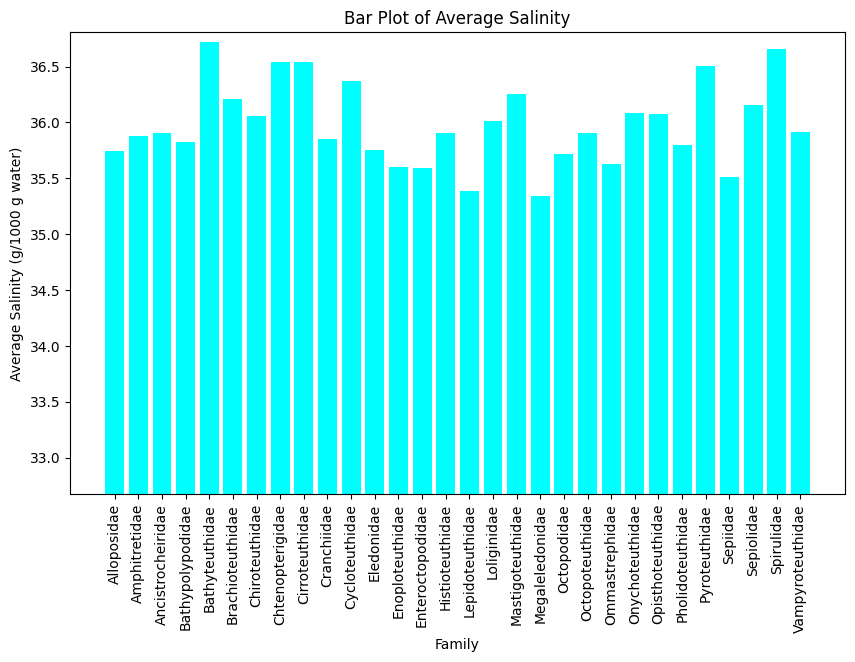

In [ ]:
# Define plot space
fig, ax = plt.subplots(figsize=(10, 6))

# Define x and y axes
ax.bar(mean_salinity_order.index,
       mean_salinity_order["mean"], #uses mean salinity for each order
       color = 'cyan')

#change y axis bounds to minimum and maximum observed salinity
ax.set_ylim([min_sal, max_sal])

#rotate axis ticks in order to make family names visible
plt.xticks(rotation=90)

# Set plot title and axes labels
ax.set(title = "Bar Plot of Average Salinity",
       xlabel = "Family",
       ylabel = "Average Salinity (g/1000 g water)");

#save and plot figure
plt.savefig("cephalopod_salinity.png")
plt.show()

Here, we can see that within the Canary Current, cephalopod families have some variability in the mean salinity values of captured individuals (though we have not tested the statistical significance of these differences).

This indicates that salinity may have a role in determining the niches occupied by different cephalopod families. However, it is unclear if this is a causal relationship (i.e. there is also a chance that some variable which correlates with salinity is determining these differences). Also, considering the relatively narrow range of salinity values in the Canary Current to begin with, there is some doubt as to how much these small differences in salinity could limit these families' distributions.